# Semi-Supervised Learning with LSTMs

In [33]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from os import listdir
from os.path import isfile, join
from random import randint
import re
import tensorflow as tf

In [62]:
# Smoothing

def savitzky_golay(y, window_size, order, deriv=0, rate=1):

    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

# Loading Data 

In [34]:
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


In [35]:
positiveFiles = ['positiveReviews/' + f for f in listdir('positiveReviews/') if isfile(join('positiveReviews/', f))]
negativeFiles = ['negativeReviews/' + f for f in listdir('negativeReviews/') if isfile(join('negativeReviews/', f))]

In [36]:
maxSeqLength = 250
numDimensions = 50

In [37]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [38]:
# ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
# fileCounter = 0
# for pf in positiveFiles:
#    with open(pf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 

# for nf in negativeFiles:
#    with open(nf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 
# #Pass into embedding function and see if it evaluates. 

# np.save('idsMatrix', ids)

In [39]:
ids = np.load('idsMatrix.npy')

# Helper Functions - Supervised Learning

In [40]:


def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,11499)
            labels.append([1,0])
        else:
            num = randint(13499,24999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(11499,13499)
        if (num <= 12499):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getAllTrainData():
    batches = []
    for j in range(25000 / batchSize):
        labels = []
        arr = np.zeros([batchSize, maxSeqLength])
        for k, i in enumerate(range(j * batchSize + 1, (j + 1) * batchSize + 1)):
            if(i <= 12499):
                labels.append([1,0])
            else:
                labels.append([0,1])
            arr[k] = ids[i-1:i]
        batches.append((arr, labels))
    return batches
            

# LSTM Model

The following is the code we use to construct a base learner that learns to predict a given set of labeled data. It computes word embeddings for each word in a sequence, and uses this sequence of vectors as input states to the LSTM cell, before making a prediction for the class of a sequence as a linear function of the output of the LSTM cell. 

In [41]:
batchSize = 24
lstmUnits = 32
numClasses = 2
iterations = 20001

In [42]:
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

In [43]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors, input_data)

In [44]:
lstmCell = tf.contrib.rnn.GRUCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [45]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [46]:
softmax = tf.nn.softmax(prediction)
normalized = tf.nn.l2_normalize(softmax,1)
confidence = tf.reduce_max(normalized,1)
predictedLabels = tf.argmax(prediction,1)
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [47]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

# Supervised Training

In [56]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
with tf.Session() as sess:
    writer = tf.summary.FileWriter(logdir, sess.graph)

In [37]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(iterations):
   #Next Batch of reviews
   nextBatch, nextBatchLabels = getTrainBatch();
   sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
   #Write summary to Tensorboard
   if (i % 50 == 0):
       summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
       writer.add_summary(summary, i)

   #Save the network every 10,000 training iterations
   if (i % 10000 == 0 and i != 0):
       save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
       print("saved to %s" % save_path)
writer.close()

saved to models/pretrained_lstm.ckpt-10000
saved to models/pretrained_lstm.ckpt-20000


# Results

In [48]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-20000


INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-20000


In [49]:
iterations = 30
accuracy_average = 0
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    accuracy_average += (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) / iterations
print accuracy_average

0.876388891538


In [50]:
confidences = np.zeros(25000)
predictions = np.zeros(25000)
batches = getAllTrainData()
for i, batch in enumerate(batches):
    batch_begin = i * batchSize + 1
    batch_end = (i + 1) * batchSize + 1
    trainBatch, trainBatchLabels = batch
    confidence_vals = sess.run(confidence, {input_data: trainBatch, labels: trainBatchLabels})
    prediction_vals = sess.run(predictedLabels, {input_data: trainBatch, labels: trainBatchLabels})
    confidences[batch_begin:batch_end] = confidence_vals
    predictions[batch_begin:batch_end] = prediction_vals

# Helper Functions - Semi-Supervised Learning

In [51]:
from random import randint
confidence_thresh = .99998
labeled_prop = .1
labeled_count = int(labeled_prop * 11499)

def getLabeledTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,labeled_count)
            labels.append([1,0])
        else:
            num = randint(13499,13499 + labeled_count)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getUnlabeledTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):       
        if (i % 2 == 0): 
            num = randint(2000,11499)     
        else:
            num = randint(15500,24999)
        while(confidences[num] < confidence_thresh):
            if (i % 2 == 0): 
                num = randint(labeled_count + 1,11499)     
            else:
                num = randint(13499 + labeled_count + 1,24999)
        if (predictions[num] == 0):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

# Initial Training with Labeled Data

In [59]:
iterations = 20001
sess = tf.InteractiveSession()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(iterations):
   #Next Batch of reviews
   nextBatch, nextBatchLabels = getLabeledTrainBatch();
   sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
   #Write summary to Tensorboard
   if (i % 50 == 0):
       summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
       writer.add_summary(summary, i)

   #Save the network every 10,000 training iterations
   if (i % 10000 == 0 and i != 0):
       save_path = saver.save(sess, "initial_models/initial_lstm.ckpt", global_step=i)
       print("saved to %s" % save_path)
writer.close()

saved to initial_models/initial_lstm.ckpt-10000


KeyboardInterrupt: 

# Evaluation of Initial Model

In [52]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('initial_models'))

INFO:tensorflow:Restoring parameters from initial_models/initial_lstm.ckpt-10000


INFO:tensorflow:Restoring parameters from initial_models/initial_lstm.ckpt-10000


In [165]:
iterations = 50
accuracy_average = 0
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    accuracy_average += (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) / iterations
print()"Initial Accuracy" + str(accuracy_average))

0.751666665077


In [53]:
confidences = np.zeros(25000)
predictions = np.zeros(25000)
batches = getAllTrainData()
for i, batch in enumerate(batches):
    batch_begin = i * batchSize + 1
    batch_end = (i + 1) * batchSize + 1
    trainBatch, trainBatchLabels = batch
    confidence_vals = sess.run(confidence, {input_data: trainBatch, labels: trainBatchLabels})
    prediction_vals = sess.run(predictedLabels, {input_data: trainBatch, labels: trainBatchLabels})
    confidences[batch_begin:batch_end] = confidence_vals
    predictions[batch_begin:batch_end] = prediction_vals

# Generating a threshold

In [61]:
thresh_vals = []
num_vals = []
accuracy_vals = []
for val in np.logspace(1, 10, 10, endpoint=True, base=.4):
    thresh = 1 - val
    thresh_below = 1.1
    print thresh
    total = right = 0.0
    for i in range(labeled_count, 11499):
        if(thresh_below > confidences[i] > thresh):
            total += 1.0
            if(predictions[i] == 0):
                right += 1.0
    for i in range(13499 + labeled_count,25000):
        if(thresh_below > confidences[i] > thresh):
            total += 1.0
            if(predictions[i] == 1):
                right += 1.0
    accuracy_initial = right/total
    print "Accuracy of New Labeled data:" + str(accuracy_initial)
    print "Number of new labeled examples:" + str(total)
    thresh_vals.append(thresh)
    accuracy_vals.append(accuracy_initial)
    num_vals.append(total)

0.6
Accuracy of New Labeled data:0.735486054044
Number of new labeled examples:20687.0
0.84
Accuracy of New Labeled data:0.741863464973
Number of new labeled examples:20156.0
0.936
Accuracy of New Labeled data:0.748655982797
Number of new labeled examples:19531.0
0.9744
Accuracy of New Labeled data:0.755684822845
Number of new labeled examples:18910.0
0.98976
Accuracy of New Labeled data:0.761144232347
Number of new labeled examples:18283.0
0.995904
Accuracy of New Labeled data:0.768590802895
Number of new labeled examples:17549.0
0.9983616
Accuracy of New Labeled data:0.776200873362
Number of new labeled examples:16488.0
0.99934464
Accuracy of New Labeled data:0.786401145741
Number of new labeled examples:14663.0
0.999737856
Accuracy of New Labeled data:0.794349429913
Number of new labeled examples:11928.0
0.9998951424
Accuracy of New Labeled data:0.793617516888
Number of new labeled examples:8586.0


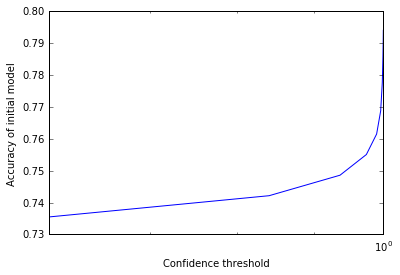

In [84]:
ax = plt.subplot(111)
ax.set_xscale('log')
ax.set_xlim(left=.6, right=1)
plt.plot(thresh_vals, savitzky_golay(np.array(accuracy_vals),7, 3))
plt.ylabel('Accuracy of initial model')
plt.xlabel('Confidence threshold')

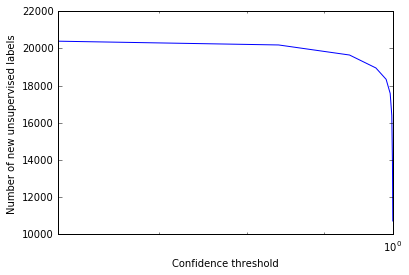

In [85]:
ax = plt.subplot(111)
ax.set_xscale('log')
ax.set_xlim(left=.6, right=1)
plt.plot(thresh_vals, savitzky_golay(np.array(num_vals),7, 3))
plt.ylabel('Number of new unsupervised labels')
plt.xlabel('Confidence threshold')

# Unsupervised learning

In [166]:
num_steps = 5
accuracy_arr = np.zeros(num_steps + 1)
accuracy_arr[0] = accuracy_average

In [167]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('initial_models'))
saver.save(sess, "unsupervised_models/unsupervised_lstm.ckpt", global_step=0)

INFO:tensorflow:Restoring parameters from initial_models/initial_lstm.ckpt-10000


INFO:tensorflow:Restoring parameters from initial_models/initial_lstm.ckpt-10000


'unsupervised_models/unsupervised_lstm.ckpt-0'

In [144]:
def run_iteration_unsupervised(j):
    print("Running unsupervised iteration: " + str(j))
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('unsupervised_models'))
    logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    iterations = 5001
    for i in range(iterations):
        
       nextBatch, nextBatchLabels = getLabeledTrainBatch();
       sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
       nextBatch, nextBatchLabels = getUnlabeledTrainBatch();
       sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
        
       #Write summary to Tensorboard
       if (i % 50 == 0):
           summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
           writer.add_summary(summary, i)

       #Save the network every 5,000 training iterations
       if (i % 5000 == 0 and i != 0):
           save_path = saver.save(sess, "unsupervised_models/unsupervised_lstm.ckpt", global_step=i + iterations * j)
           print("saved to %s" % save_path)
    writer.close()

In [145]:
def get_accuracy_unsupervised():
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('unsupervised_models'))
    iterations = 50
    accuracy_average = 0
    for i in range(iterations):
        nextBatch, nextBatchLabels = getTestBatch();
        accuracy_average += (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) / iterations
    return accuracy_average

In [146]:
def update_confidences_unsupervised():
    sess = tf.InteractiveSession()
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('unsupervised_models'))
    for i, batch in enumerate(batches):
        batch_begin = i * batchSize + 1
        batch_end = (i + 1) * batchSize + 1
        trainBatch, trainBatchLabels = batch
        confidence_vals = sess.run(confidence, {input_data: trainBatch, labels: trainBatchLabels})
        prediction_vals = sess.run(predictedLabels, {input_data: trainBatch, labels: trainBatchLabels})
        confidences[batch_begin:batch_end] = confidence_vals
        predictions[batch_begin:batch_end] = prediction_vals

In [169]:
for j in range(num_steps):
    run_iteration_unsupervised(j)
    accuracy_current = get_accuracy_unsupervised()
    accuracy_arr[j + 1] = accuracy_current
    print("Accuracy after " + str(j + 1) + " Iterations: " + str(accuracy_current)) 
    update_confidences_unsupervised()

Running unsupervised iteration: 0
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-0


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-0


saved to unsupervised_models/unsupervised_lstm.ckpt-5000
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-5000


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-5000


Accuracy after 1 Iterations: 0.758333331347
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-5000


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-5000


Running unsupervised iteration: 1
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-5000


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-5000


saved to unsupervised_models/unsupervised_lstm.ckpt-10001
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-10001


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-10001


Accuracy after 2 Iterations: 0.779166674614
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-10001


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-10001


Running unsupervised iteration: 2
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-10001


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-10001


saved to unsupervised_models/unsupervised_lstm.ckpt-15002
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-15002


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-15002


Accuracy after 3 Iterations: 0.804166668653
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-15002


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-15002


Running unsupervised iteration: 3
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-15002


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-15002


saved to unsupervised_models/unsupervised_lstm.ckpt-20003
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-20003


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-20003


Accuracy after 4 Iterations: 0.804166668653
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-20003


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-20003


Running unsupervised iteration: 4
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-20003


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-20003


saved to unsupervised_models/unsupervised_lstm.ckpt-25004
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-25004


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-25004


Accuracy after 5 Iterations: 0.783333331347
INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-25004


INFO:tensorflow:Restoring parameters from unsupervised_models/unsupervised_lstm.ckpt-25004


# Graph Results

In [1]:
# Accuracy results without retraining the whole thing
accuracy_arr = [0.7516, 0.7583, 0.7791, 0.8041, 0.8041, 0.7833]

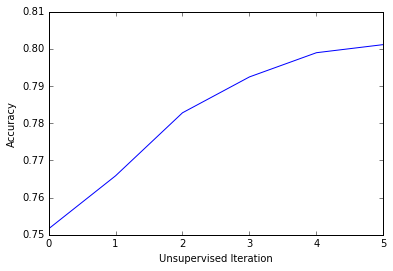

In [23]:
plt.plot(savitzky_golay(np.array(accuracy_arr),7, 2))
plt.ylabel('Accuracy')
plt.xlabel('Unsupervised Iteration')
plt.savefig('Accuracy.png', dpi=300, bbox_inches='tight')